<a href="https://colab.research.google.com/github/KeyMoney22/Plant_disease_classification-/blob/main/tomato_disease_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 1. Importing Relevant Libraries

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import os
from PIL import Image
from tensorflow.keras import models, layers

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:

# Mount Google Drive
#drive.mount('/content/drive')

# Navigate to your folder
folder_path = r"C:\Users\Victor Keya\Documents\Flatiron\Phase5_Capstone\PlantVillage"

## 2. Loading our dataset.

In [4]:
data= tf.keras.utils.image_dataset_from_directory(folder_path, labels='inferred', label_mode='categorical',
                                            class_names=None, color_mode='rgb', batch_size=32,
                                            image_size=(224, 224), shuffle=True, seed=None,
                                            validation_split=None, subset=None, interpolation='bilinear',
                                            follow_links=False, crop_to_aspect_ratio=False)

Found 16011 files belonging to 10 classes.


In [5]:
# Checking and printing the length of our data
print('The length of our data is', len(data))

# Checking the shape of our images and labels
for image_batch, label_batch in data:
  print('Image Batch Shape', image_batch.shape)
  print('Label Batch Shape', label_batch.shape)
  break
  #3 = rgb
  #32 = batch size
  # 256, 256= height , weight

The length of our data is 501
Image Batch Shape (32, 224, 224, 3)
Label Batch Shape (32, 10)


# Visualizing some of our images

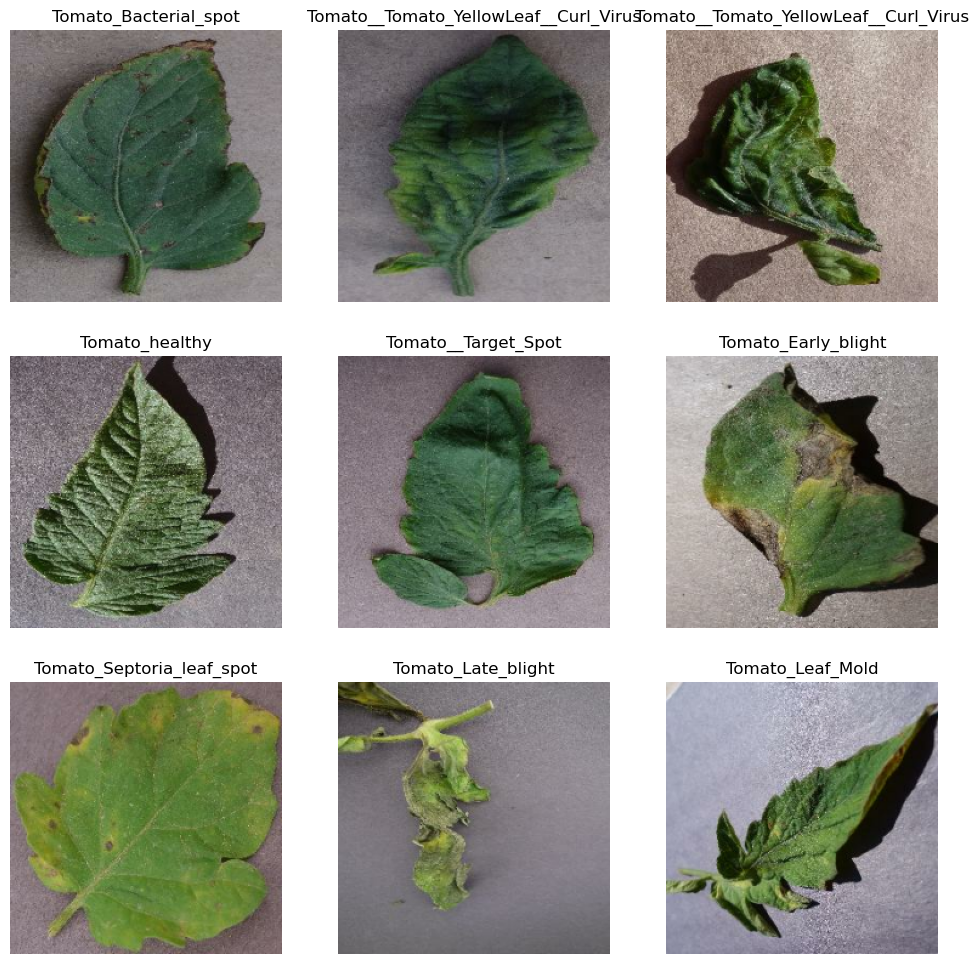

In [6]:
def preview_data(dataset, class_names, num_images=9):
    plt.figure(figsize=(12, 12))
    for images, labels in dataset.take(1):
        for i in range(num_images):
            ax = plt.subplot(3, 3, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[tf.argmax(labels[i])])
            plt.axis("off")#hide the numbers
    plt.show()

class_names = data.class_names
preview_data(data, class_names)

## 3. Data Cleaning and Preperation

**Cleaning the class names**

In [7]:
#Checking our class names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [8]:
# Cleaning and printing the formarted class names
def clean_class_name(name):
    name = name.replace('__', '_')
    name = name.replace('__', '_')
    if name == 'Tomato_Spider_mites_Two_spotted_spider_mite':
        name = 'Tomato_Spider_mites'
    elif name == 'Tomato_Tomato_YellowLeaf_Curl_Virus':
        name = 'Tomato_Yellow_Leaf_Curl_Virus'
    elif name == 'Tomato_Tomato_mosaic_virus':
        name = 'Tomato_Mosaic_Virus'
    name = name.lower()
    return name

class_names = [clean_class_name(name) for name in class_names]
class_names

['tomato_bacterial_spot',
 'tomato_early_blight',
 'tomato_late_blight',
 'tomato_leaf_mold',
 'tomato_septoria_leaf_spot',
 'tomato_spider_mites',
 'tomato_target_spot',
 'tomato_yellow_leaf_curl_virus',
 'tomato_mosaic_virus',
 'tomato_healthy']

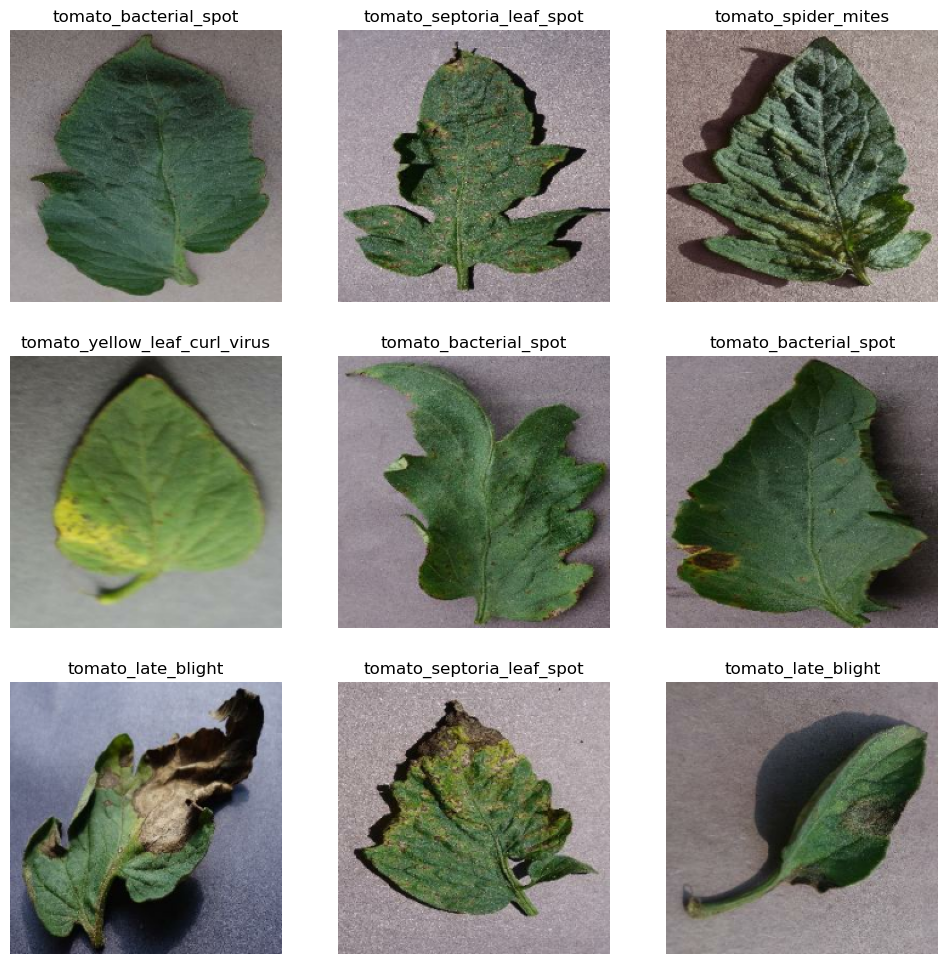

In [9]:
preview_data(data, class_names)

**Checking for Corrupt images**

In [10]:
def check_corrupt_images(folder_path):
    corrupt_images = []
    for root, _, files in os.walk(folder_path):
        for file in files:
            try:
                img = Image.open(os.path.join(root, file))
                img.verify()  # Verify that it is, in fact, an image
            except (IOError, SyntaxError) as e:
                corrupt_images.append(os.path.join(root, file))
    return corrupt_images

corrupt_images = check_corrupt_images(folder_path)
print(f"Found {len(corrupt_images)} corrupt images.")

Found 0 corrupt images.


In [11]:
# Data Preparation
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_set = train_datagen.flow_from_directory(
    folder_path,  # Replace with your dataset directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_set = train_datagen.flow_from_directory(
    folder_path,  # Replace with your dataset directory
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

Found 12813 images belonging to 10 classes.
Found 3198 images belonging to 10 classes.


**Class Distribution**

In [12]:
# A function to check class distribution
def check_class_distribution(dataset):
    class_counts = {}
    for images, labels in dataset:
        for label in labels:
            class_name = class_names[tf.argmax(label)]
            if class_name in class_counts:
                class_counts[class_name] += 1
            else:
                class_counts[class_name] = 1
    return class_counts

# Checking class distribution
class_distribution = check_class_distribution(data)

# Sorting the dictionary by values (class counts) in ascending order
sorted_class_distribution = dict(sorted(class_distribution.items(), key=lambda item: item[1]))

print("Sorted class distribution (ascending):", sorted_class_distribution)


Sorted class distribution (ascending): {'tomato_mosaic_virus': 373, 'tomato_leaf_mold': 952, 'tomato_early_blight': 1000, 'tomato_target_spot': 1404, 'tomato_healthy': 1591, 'tomato_spider_mites': 1676, 'tomato_septoria_leaf_spot': 1771, 'tomato_late_blight': 1909, 'tomato_bacterial_spot': 2127, 'tomato_yellow_leaf_curl_virus': 3208}


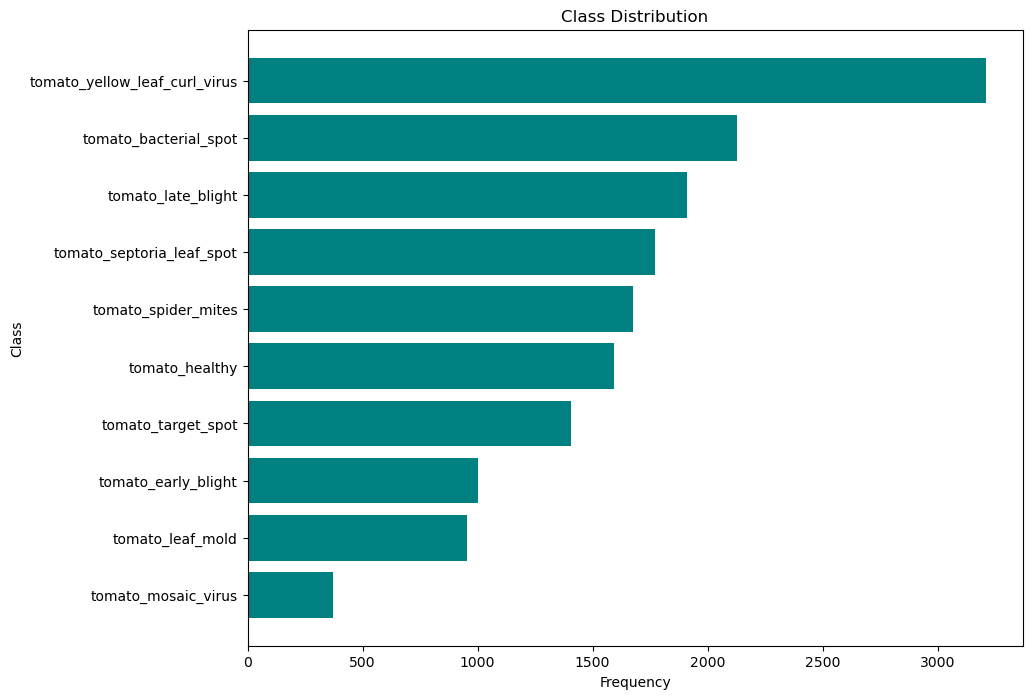

In [13]:
# Visualize class distribution with a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(list(sorted_class_distribution.keys()), list(sorted_class_distribution.values()), color='Teal')
plt.title('Class Distribution')
plt.xlabel('Frequency')
plt.ylabel('Class')
plt.show();

In our dataset, there is Class imbalance as observed in the graph above, leaf_curl_virus has the highest number of 3208 while tomato mosaic virus with the least observations of 373 as seen on the graph above.

**Splitting our data set**

In [14]:
train_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,  # Set a seed for reproducibility
    validation_split=0.2,  # Use 20% of the data for validation
    subset='training',  # Specify this is the training subset
    interpolation='bilinear'
)

val_data = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=123,
    validation_split=0.2,  # Same split for validation
    subset='validation',  # Specify this is the validation subset
    interpolation='bilinear'
)
test_set = tf.keras.utils.image_dataset_from_directory(
    folder_path,
    labels='inferred',
    label_mode='categorical',
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False  # Typically set to False for evaluation
)

Found 16011 files belonging to 10 classes.
Using 12809 files for training.
Found 16011 files belonging to 10 classes.
Using 3202 files for validation.
Found 16011 files belonging to 10 classes.


In [15]:
print("Train data element spec:", train_data.element_spec)
print("Validation data element spec:", val_data.element_spec)

Train data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation data element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [16]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectivly
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):
  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size).skip(val_size)

  return train_set, val_set, test_set
# Define the get_subset function if it's not defined elsewhere
#def get_subset(dataset, fraction):
 # """
 # Returns a subset of the given dataset.

  #Args:
   # dataset: The dataset to extract a subset from.
    #fraction: The fraction of the dataset to return.

  #Returns:
   # A subset of the original dataset.
  #"""
  #subset_size = int(len(dataset) * fraction)
  #return dataset.take(subset_size)

# Data Subset
#train_subset = get_subset(train_set, 1/3)
#val_subset = get_subset(val_set, 1/3)
#test_subset = get_subset(test_set, 1/3)

In [17]:
# Printing the length of our train, validation and test data
train_set, val_set, test_set = split_data(data)
print(len(train_set))
print(len(val_set))
print(len(test_set))

400
50
51


# Data Modeling

In [18]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
img_size = 224

# Creating an instance to Resize our data
resize_and_rescale = tf.keras.Sequential([
                layers.Resizing(img_size,img_size),
                layers.Rescaling(1.0/255)
])

# Creating a data augmentation instance for our data
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip('horizontal_and_vertical'),
    layers.RandomRotation(0.2)

])

In [20]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

In [21]:
input_shape = (img_size, img_size)
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3), activation = 'relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2))
])

C:\Users\Victor Keya\Documents\Anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [22]:
# Creating a split of our data into train, validation and 80% ,10% and 10% Respectively
def split_data(data, train_split = 0.8, val_split = 0.1, test_split = 0.1, shuffle=True, shuffle_size=10000):

  # Calculating the length of our dataset
  data_size = len(data)
  if shuffle:
    data = data.shuffle(shuffle_size) #Shuffling our data
  train_size = int(train_split* len(data))
  val_size = int(val_split*len(data))

  train_set = data.take(train_size)
  val_set = data.skip(train_size).take(val_size)
  test_set = data.skip(train_size + val_size)

  return train_set, val_set, test_set

# Define the get_subset function if it's not defined elsewhere
def get_subset(dataset, fraction):
  """
  Returns a subset of the given dataset.

  Args:
    dataset: The dataset to extract a subset from.
    fraction: The fraction of the dataset to return.

  Returns:
    A subset of the original dataset.
  """
  subset_size = int(len(dataset) * fraction)
  return dataset.take(subset_size)

# Data Subset
train_subset = get_subset(train_set, 1/3)
val_subset = get_subset(val_set, 1/3)
test_subset = get_subset(test_set, 1/3)

In [23]:
print("Train set element spec:", train_set.element_spec)
print("Validation set element spec:", val_set.element_spec)
print("Test set element spec:", test_set.element_spec)

Train set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Test set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [24]:
# Resizing and normalizing images 
def preprocess_data(dataset, image_size=(224, 224)):
    def preprocess_image(image, label):
        image = tf.image.resize(image, image_size)  # Resize images to 224x224
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    return dataset.map(preprocess_image)

In [25]:
# apply preprocessing 
train_set = preprocess_data(train_subset)
val_set = preprocess_data(val_subset)
test_set = preprocess_data(test_subset)

In [26]:
# loading MobileNet V3 Model
from tensorflow.keras.applications import MobileNetV3Small

# Load MobileNet V3 model
base_model = MobileNetV3Small(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model
base_model.trainable = True

In [27]:
#Build the model using MobileNetV3
from tensorflow.keras.applications import MobileNetV3Small
from tensorflow.keras import layers, models

# Define the base model
base_model = MobileNetV3Small(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = True  # Make the base model layers trainable

# Number of classes in your dataset
num_classes = 10  # Replace this with the actual number of classes

# Add custom layers on top of the base model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')  # Adjust the number of classes to match the dataset
])

lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1
)

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Print model summary to verify parameter counts
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobilenetV3small (Functional)   │ ?                      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ ?                      │   0 (unbuilt) │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 939,120 (3.58 MB)

 Trainable params: 927,008 (3.54 MB)

 Non-trainable params: 12,112 (47.31 KB)

In [28]:
print("Train set element spec:", train_set.element_spec)
print("Validation set element spec:", val_set.element_spec)
print("Test set element spec:", test_set.element_spec)

Train set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Validation set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))
Test set element spec: (TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None))


In [29]:
# Resizing and normalizing images 
def preprocess_data(dataset, image_size=(224, 224)):
    def preprocess_image(image, label):
        image = tf.image.resize(image, image_size)  # Resize images to 224x224
        image = image / 255.0  # Normalize pixel values to [0, 1]
        return image, label

    return dataset.map(preprocess_image)

In [30]:
# Compiling model 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',  # Use 'categorical_crossentropy' for one-hot encoded labels
              metrics=['accuracy'])

In [31]:
# Define the EarlyStopping callback
# Training Model
history = model.fit(train_set,  # Adjust batch size as needed
                    validation_data=val_set,
         
                    epochs=10)  # Adjust the number of epochs as needed

# Evaluate the model
#test_loss, test_accuracy = model.evaluate(val_set)
#print(f"Test accuracy: {test_accuracy * 100:.2f}%")

Epoch 1/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 374s 2s/step - accuracy: 0.4376 - loss: 1.7069 - val_accuracy: 0.1328 - val_loss: 3.5522
Epoch 2/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 136s 974ms/step - accuracy: 0.8193 - loss: 0.5669 - val_accuracy: 0.1465 - val_loss: 2.6479
Epoch 3/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.9041 - loss: 0.3090 - val_accuracy: 0.1191 - val_loss: 4.6304
Epoch 4/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 116s 870ms/step - accuracy: 0.9252 - loss: 0.2485 - val_accuracy: 0.1992 - val_loss: 4.9102
Epoch 5/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 134s 1s/step - accuracy: 0.9411 - loss: 0.2068 - val_accuracy: 0.1289 - val_loss: 8.1134
Epoch 6/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 121s 910ms/step - accuracy: 0.9559 - loss: 0.1489 - val_accuracy: 0.1328 - val_loss: 5.6056
Epoch 7/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 169s 1s/step - accuracy: 0.9511 - loss: 0.1464 - val_accuracy: 0.1953 - val_loss: 2.9794
Epoch 8/10
133/133 ━━━━━━━━━━━━━━━━━━━━ 121s 914ms/step - accuracy: 0.9720 - loss: 0.106

In [32]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_set)
print(f'Test accuracy: {test_accuracy:.2f}')

17/17 ━━━━━━━━━━━━━━━━━━━━ 113s 421ms/step - accuracy: 0.1266 - loss: 6.7718
Test accuracy: 0.13


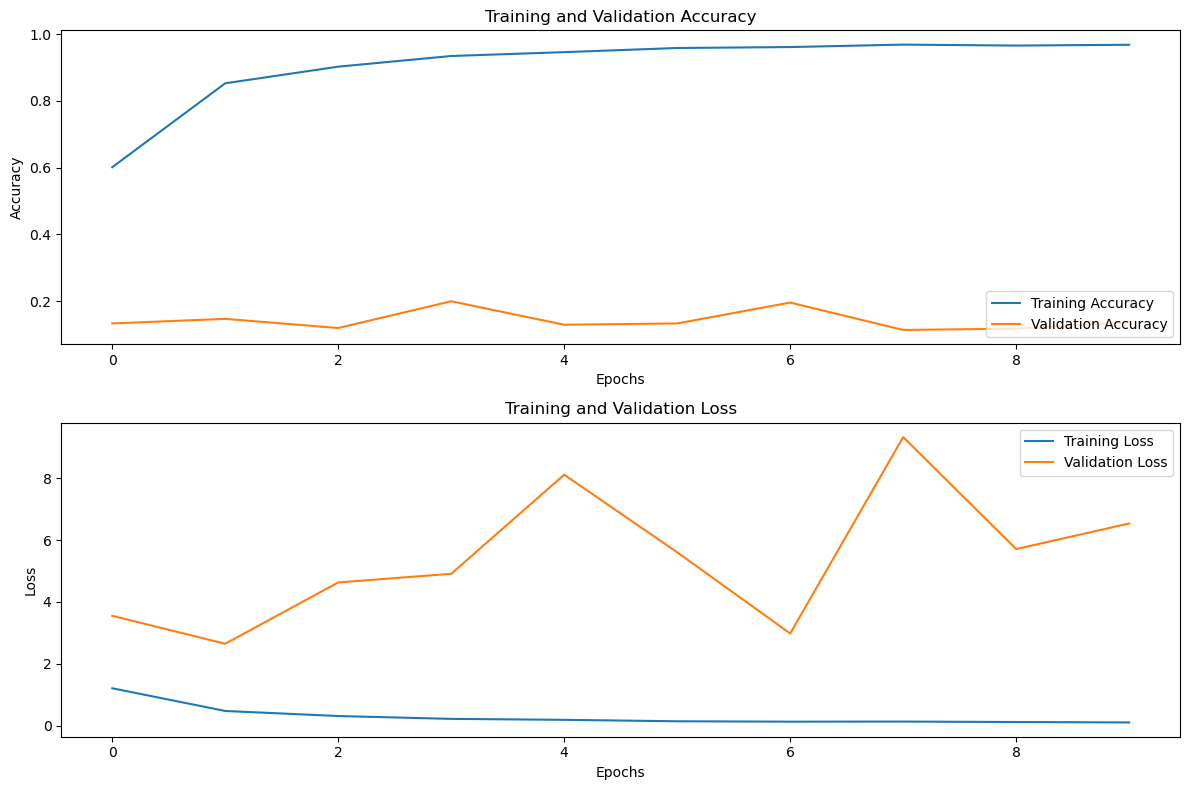

In [33]:
import matplotlib.pyplot as plt

# Extracting accuracy and loss from the history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Plotting Training and Validation Accuracy
plt.figure(figsize=(12, 8))

# Accuracy plot
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

# Loss plot
plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()